# Purpose of notebook
This notebook is explore the win/loss classification problem. The goal of this analysis is to identify what attributes are good at predicting match outcomes, in different senarios. 


Topics covered:
- data pre-processing
- basic logistic regression model (baseline model?)
- Overall round dataset
- Data set broken up by attacker vs defender
- Data set broken up by spike planted vs not spike planted


## Additional background / hypothesis
* To win a match of valorant, you need to win 13 rounds (5 if swiftplay)
    - To win a round, how you win is dependent on if you are attacker or defender
        - If attacker, you win by either planting the spike and it detonates, or you eliminate all opponents
        - If defender, you win by either deativating a planted spike, eliminating all opponents, or just suriving without the spike being planted


* Hypothesis is depending on if you are attacker or defender, and if the spike has been planted or not, your strategy will change
    - More specifically, if you are attacker what will help you win will probably be elims, not dying, spike planting
    - If you are defender what will help you win is not dying, deacitivaitng spike
    - Depending on what is happning in the match (most obviously pre spike and post spike) the things you should focus on to win will change
    - Ideas: 
        - if you are an attacker and the spike is not planted, at least 2? or more of your teammates should focus on planting the spike (depending on your role!!)
        - if you are an attacker and the spike is planted, all teammates should focus on defending the spike and killing the other team
        - if you are a defender and the spike is not planted, the team should focus on kills
        - if you are a defender and the spike is planted, the team should focus on kills/deativating the spike
        - also just stay alive
    
### Questions:
- Spike planted is usually tracked, is spike detonated tracked?



In [1]:
import json
import pandas as pd

## Loading the data

In [2]:
# Load JSON data from file
with open('dev_data.json', 'r') as f:
    data = json.load(f)

# Access an element to retrieve the keys
sample_element = data[0]
columns = sample_element.keys()
print("Columns:", columns)

num_rows = len(data)
print("Number of rows:", num_rows)

Columns: dict_keys(['id', 'game_id', 'map_id', 'processed', 'process_date', 'created_at', 'updated_at', 'match_id', 'result', 'score', 'statistics', 'totals', 'ten_minute_averages', 'character_id', 'user_id', 'match_length', 'video_id', 'card_url', 'total_time', 'totals_to_date', 'start_time', 'end_time', 'start_frame', 'end_frame', 'status', 'report', 'analysis_processed', 'analysis_status'])
Number of rows: 534


## Create Rounds DF
- Create DF
- Go to statistics col
- flatten the column
- pull out totals, character, map

In [3]:
from pandas import json_normalize

# Create df
df = pd.read_json('dev_data.json')
print(df.shape)

# Drop the all cols besides 'statistics' and 'user_id'
df_stats = df[['user_id','statistics']]
print(df_stats.shape)
df_stats

(534, 28)
(534, 2)


,user_id,statistics
0,1006,"{'map': 'Pearl', 'score': '13-3', 'allies': ['..."
1,1006,"{'map': 'Haven', 'score': '9-13', 'allies': ['..."
2,1006,"{'map': 'Split', 'score': '13-4', 'allies': ['..."
3,1011,"{'map': 'Fracture', 'score': '14-12', 'allies'..."
4,1011,"{'map': 'Haven', 'score': '13-10', 'allies': [..."
...,...,...
529,1010,"{'map': 'Ascent', 'score': '13-8', 'allies': [..."
530,1011,"{'map': 'Bind', 'score': '14-12', 'allies': ['..."
531,1011,"{'map': 'unknown', 'score': '13-11', 'allies':..."
532,1018,"{'map': 'Split', 'score': '13-4', 'allies': ['..."


### Flattening the stats col by 1 level

In [4]:
flat1_df_stats = pd.json_normalize(df_stats['statistics'], max_level=0)
flat1_df_stats = pd.concat([df_stats['user_id'], flat1_df_stats], axis=1)
print(flat1_df_stats.shape)
flat1_df_stats

(534, 34)


,user_id,map,score,allies,player,result,rounds,status,totals,version,...,best_weapon_type,best_weapon_elims,detections_totals,most_used_primary,analysis_processed,opponents_onscreen,most_used_secondary,best_weapon_type_elims,most_used_primary_seconds,most_used_secondary_seconds
0,1006,Pearl,13-3,"[0, 1, 2, 3, 4]",1,win,"{'7': {'alive': {'0': [[0, True], [4800, False...",success: completed - valorant final,"{'elims': 9, 'deaths': 3, 'assists': 2, 'heali...",1.0.0,...,primary,4,"{'7': {'final_time': 19850, 'initial_size': {'...",vandal,True,"{'5250': 0, '19600': 1, '22150': 0, '28700': 1...",sheriff,5,309,109
1,1006,Haven,9-13,"[0, 1, 2, 3, 4]",4,loss,"{'0': {'alive': {'0': [[95000, True], [140000,...",success: completed - valorant final,"{'elims': 21, 'deaths': 17, 'assists': 0, 'hea...",1.0.0,...,primary,9,"{'26': {'final_time': 46900, 'initial_size': {...",vandal,True,"{'14200': 0, '46450': 1, '50800': 0, '60100': ...",ghost,14,298,94
2,1006,Split,13-4,"[0, 1, 2, 3, 4]",3,win,"{'0': {'alive': {'0': [[3600, True], [50600, F...",success: completed - valorant final,"{'elims': 32, 'deaths': 8, 'assists': 3, 'heal...",1.0.0,...,primary,4,"{'55': {'final_time': 78100, 'initial_size': {...",vandal,True,"{'1600': 0, '77900': 1, '78000': 0, '78100': 1...",sheriff,12,192,195
3,1011,Fracture,14-12,"[0, 1, 2, 3, 4]",0,win,"{'0': {'alive': {'0': [[110199, True], [175399...",success: completed - valorant final,"{'elims': 14, 'deaths': 12, 'assists': 12, 'he...",1.0.0,...,primary,6,"{'51': {'final_time': 117249, 'initial_size': ...",vandal,True,"{'33799': 0, '116999': 1, '117299': 0, '125449...",frenzy,10,1455,137
4,1011,Haven,13-10,"[0, 1, 2, 3, 4]",2,win,"{'0': {'alive': {'0': [[73399, True], [153799,...",success: completed - valorant final,"{'elims': 15, 'deaths': 16, 'assists': 6, 'hea...",1.0.0,...,primary,8,"{'33': {'final_time': 91399, 'initial_size': {...",vandal,True,"{'6199': 0, '91199': 1, '92299': 0, '92349': 1...",frenzy,9,1131,291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,1010,Ascent,13-8,"[0, 1, 2, 3, 4]",0,win,"{'0': {'alive': {'0': [[49789, True], [71389, ...",success: completed - valorant postprocess,"{'elims': 12, 'deaths': 11, 'assists': 9, 'hea...",NaN,...,primary,4,NaN,vandal,NaN,NaN,ghost,7,507,157
530,1011,Bind,14-12,"[0, 1, 2, 3, 4]",0,win,"{'0': {'alive': {'0': [[44988, True], [88188, ...",success: completed - valorant postprocess,"{'elims': 24, 'deaths': 19, 'assists': 8, 'hea...",NaN,...,primary,8,NaN,phantom,NaN,NaN,frenzy,12,1268,105
531,1011,unknown,13-11,"[0, 1, 2, 3, 4]",0,win,"{'0': {'alive': {'0': [[9, True], [113209, Fal...",success: completed - valorant postprocess,"{'elims': 23, 'deaths': 16, 'assists': 6, 'hea...",NaN,...,primary,8,NaN,vandal,NaN,NaN,ghost,12,664,139
532,1018,Split,13-4,"[0, 1, 2, 3, 4]",3,win,"{'0': {'alive': {'0': [[199, True], [168177, F...",success: completed - valorant postprocess,"{'elims': 11, 'deaths': 14, 'assists': 6, 'hea...",NaN,...,primary,3,NaN,phantom,NaN,NaN,sheriff,6,294,39


### Removing some cols we don't care about from the ROUND perspective
- Just to see how it would work I am keeping map (this is from the match perspective) 

In [5]:
# Keep in mind the 'totals', 'result' are from the MATCH perspective
# I don't really know what to do with 'detections_totals' so I am dropping it for now
# The best weapon/most used/player_totals (weapon) is again from a match perspective
# I think 'allies_onscreen' and 'opponents_onscreen' could be useful but it is from match perspective

# Just to see how it would work I am keeping map (this is from the match perspective) 

flat1_df_stats = flat1_df_stats.drop(['totals','score', 'allies','result', 'status','version','end_time','opponents','processed','ally_score','start_time','opponent_score','detections_totals','best_weapon_type','best_weapon_elims','most_used_primary_seconds','analysis_processed','most_used_secondary_seconds','best_weapon_type_elims','opponents_onscreen','allies_onscreen','analysis_status','best_weapon','player_totals','most_used_primary','most_used_secondary'], axis=1)
flat1_df_stats['gametype'] = flat1_df_stats['gametype'].fillna('unknown')
print(flat1_df_stats.shape)
flat1_df_stats

(534, 8)


,user_id,map,player,rounds,gametype,player_ids,round_info,round_totals
0,1006,Pearl,1,"{'7': {'alive': {'0': [[0, True], [4800, False...",swiftplay,"{'0': {'role': 'ally', 'character': 'phoenix'}...","{'7': {'score': '4-3', 'ult_used': False, 'all...","{'7': {'elims': 0, 'deaths': 1, 'assists': 0, ..."
1,1006,Haven,4,"{'0': {'alive': {'0': [[95000, True], [140000,...",swiftplay,"{'0': {'role': 'ally', 'character': 'kay/o'}, ...","{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ..."
2,1006,Split,3,"{'0': {'alive': {'0': [[3600, True], [50600, F...",swiftplay,"{'0': {'role': 'ally', 'character': 'skye'}, '...","{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 1, 'deaths': 0, 'assists': 0, ..."
3,1011,Fracture,0,"{'0': {'alive': {'0': [[110199, True], [175399...",swiftplay,"{'0': {'role': 'self', 'character': 'breach'},...","{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ..."
4,1011,Haven,2,"{'0': {'alive': {'0': [[73399, True], [153799,...",swiftplay,"{'0': {'role': 'ally', 'character': 'omen'}, '...","{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ..."
...,...,...,...,...,...,...,...,...
529,1010,Ascent,0,"{'0': {'alive': {'0': [[49789, True], [71389, ...",unknown,"{'0': {'role': 'self', 'character': 'astra'}, ...","{'0': {'score': '0-0', 'ally_side': 'attacker'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ..."
530,1011,Bind,0,"{'0': {'alive': {'0': [[44988, True], [88188, ...",unknown,"{'0': {'role': 'self', 'character': 'viper'}, ...","{'0': {'score': '0-0', 'ally_side': 'defender'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ..."
531,1011,unknown,0,"{'0': {'alive': {'0': [[9, True], [113209, Fal...",unknown,"{'0': {'role': 'self', 'character': 'viper'}, ...","{'0': {'score': '0-0', 'ally_side': 'unknown',...","{'0': {'elims': 1, 'deaths': 1, 'assists': 0, ..."
532,1018,Split,3,"{'0': {'alive': {'0': [[199, True], [168177, F...",unknown,"{'0': {'role': 'ally', 'character': 'yoru'}, '...","{'0': {'score': '0-0', 'ally_side': 'defender'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ..."


In [6]:
flat1_df_stats['player_ids'][0]

{'0': {'role': 'ally', 'character': 'phoenix'},
 '1': {'role': 'self', 'character': 'jett'},
 '2': {'role': 'ally', 'character': 'gekko'},
 '3': {'role': 'ally', 'character': 'cypher'},
 '4': {'role': 'ally', 'character': 'astra'},
 '5': {'role': 'opponent', 'character': 'harbor'},
 '6': {'role': 'opponent', 'character': 'astra'},
 '7': {'role': 'opponent', 'character': 'jett'},
 '8': {'role': 'opponent', 'character': 'phoenix'},
 '9': {'role': 'opponent', 'character': 'killjoy'}}

### Flattening the player_ids col by 1 level
- To keep it simple I am just going to grab the active player (for now)

In [7]:
# Create an empty list to hold the expanded player ids
expanded_player_ids_list = []

for i, player_ids in enumerate(flat1_df_stats['player_ids']):
    mapping = {}
    for player_id, player_info in player_ids.items():
        role = player_info['role']
        if role == 'self':
            column_name = f"{role}_character"
            mapping[column_name] = player_info['character']
    
    # If mapping is not empty
    if mapping:
        expanded_player_ids_list.append(mapping)

# Create the expanded_player_ids DataFrame
expanded_player_ids = pd.DataFrame(expanded_player_ids_list)

expanded_player_ids

# Concatenate the original DataFrame with the expanded columns
flat2_df_stats_chars = pd.concat([flat1_df_stats.drop('player_ids', axis=1), expanded_player_ids], axis=1)

print(flat2_df_stats_chars.shape)
flat2_df_stats_chars

(534, 8)


,user_id,map,player,rounds,gametype,round_info,round_totals,self_character
0,1006,Pearl,1,"{'7': {'alive': {'0': [[0, True], [4800, False...",swiftplay,"{'7': {'score': '4-3', 'ult_used': False, 'all...","{'7': {'elims': 0, 'deaths': 1, 'assists': 0, ...",jett
1,1006,Haven,4,"{'0': {'alive': {'0': [[95000, True], [140000,...",swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ...",gekko
2,1006,Split,3,"{'0': {'alive': {'0': [[3600, True], [50600, F...",swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 1, 'deaths': 0, 'assists': 0, ...",jett
3,1011,Fracture,0,"{'0': {'alive': {'0': [[110199, True], [175399...",swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ...",breach
4,1011,Haven,2,"{'0': {'alive': {'0': [[73399, True], [153799,...",swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ...",fade
...,...,...,...,...,...,...,...,...
529,1010,Ascent,0,"{'0': {'alive': {'0': [[49789, True], [71389, ...",unknown,"{'0': {'score': '0-0', 'ally_side': 'attacker'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ...",astra
530,1011,Bind,0,"{'0': {'alive': {'0': [[44988, True], [88188, ...",unknown,"{'0': {'score': '0-0', 'ally_side': 'defender'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ...",viper
531,1011,unknown,0,"{'0': {'alive': {'0': [[9, True], [113209, Fal...",unknown,"{'0': {'score': '0-0', 'ally_side': 'unknown',...","{'0': {'elims': 1, 'deaths': 1, 'assists': 0, ...",viper
532,1018,Split,3,"{'0': {'alive': {'0': [[199, True], [168177, F...",unknown,"{'0': {'score': '0-0', 'ally_side': 'defender'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ...",brimstone


### Flattening the round_info/round_totals cols by 1 level
- To keep it simple I am going to drop the more detailed rounds (for now)
- Have to parse the round info/round totals at the same time
- This is where the DF expands into rounds being the rows instead of matches being the rows

In [8]:
flat2_df_stats_chars = flat2_df_stats_chars.drop(['rounds'], axis=1)
flat2_df_stats_chars

,user_id,map,player,gametype,round_info,round_totals,self_character
0,1006,Pearl,1,swiftplay,"{'7': {'score': '4-3', 'ult_used': False, 'all...","{'7': {'elims': 0, 'deaths': 1, 'assists': 0, ...",jett
1,1006,Haven,4,swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ...",gekko
2,1006,Split,3,swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 1, 'deaths': 0, 'assists': 0, ...",jett
3,1011,Fracture,0,swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ...",breach
4,1011,Haven,2,swiftplay,"{'0': {'score': '0-0', 'ult_used': False, 'all...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ...",fade
...,...,...,...,...,...,...,...
529,1010,Ascent,0,unknown,"{'0': {'score': '0-0', 'ally_side': 'attacker'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ...",astra
530,1011,Bind,0,unknown,"{'0': {'score': '0-0', 'ally_side': 'defender'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 1, ...",viper
531,1011,unknown,0,unknown,"{'0': {'score': '0-0', 'ally_side': 'unknown',...","{'0': {'elims': 1, 'deaths': 1, 'assists': 0, ...",viper
532,1018,Split,3,unknown,"{'0': {'score': '0-0', 'ally_side': 'defender'...","{'0': {'elims': 0, 'deaths': 1, 'assists': 0, ...",brimstone


In [9]:
normalized_df_round_info = pd.DataFrame()
normalized_df_round_totals = pd.DataFrame()
df_round_info_list = []
df_round_totals_list = []

for i, row in flat2_df_stats_chars.iterrows():
    normalized_df_round_info = row['round_info']
    normalized_df_round_totals = row['round_totals']
    active_player = row['player']
    user_id = row['user_id']
    game_map = row['map']
    self_character = row['self_character']
    
    # starting with the round info
    for round_num in normalized_df_round_info.keys():
        round_info_dict = normalized_df_round_info[round_num]
        round_info_dict['user_id'] = user_id
        round_info_dict['map'] = game_map
        round_info_dict['self_character'] = self_character
        df_round_info_list.append(round_info_dict)
   
    # then the round totals
    for round_num in normalized_df_round_totals.keys(): 
        round_totals_dict = normalized_df_round_totals[round_num]
        round_totals_dict['user_id'] = user_id
        round_totals_dict['map'] = game_map
        round_totals_dict['self_character'] = self_character
        df_round_totals_list.append(round_totals_dict)

# Create the dataframes outside the loop
round_info_df = pd.DataFrame(df_round_info_list)
round_totals_df = pd.DataFrame(df_round_totals_list)


In [10]:
round_info_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,opponent_score,user_id,map,self_character
0,4-3,False,attacker,-25276,124802,True,4,4723,117802,False,3,1006,Pearl,jett
1,5-3,False,attacker,124802,204402,True,5,154802,197402,False,3,1006,Pearl,jett
2,6-3,False,attacker,204402,304570,True,6,234402,297570,True,3,1006,Pearl,jett
3,7-3,False,attacker,304570,369242,True,7,334570,362242,False,3,1006,Pearl,jett
4,8-3,False,attacker,369242,448998,True,8,399242,441998,False,3,1006,Pearl,jett
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,NaN,attacker,1283681,1375064,True,8,1313681,1368064,NaN,7,1018,Lotus,sage
8042,9-7,NaN,attacker,1375064,1439659,True,9,1405064,1432659,NaN,7,1018,Lotus,sage
8043,10-7,NaN,attacker,1439659,1504595,True,10,1469659,1497595,NaN,7,1018,Lotus,sage
8044,11-7,NaN,attacker,1504595,1600300,True,11,1534595,1593300,NaN,7,1018,Lotus,sage


### Data cleaning
- I noticed some NaNs. This happens when there is missing information
- After investigating it seems like the ult_used and the spike_planted wasn't always captured
- round_totals_df is good though
- 1220 rows total which is sort of a lot (%15 of data)
- seems like 'uknown' is common so ill do that

In [11]:
round_info_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,opponent_score,user_id,map,self_character
0,4-3,False,attacker,-25276,124802,True,4,4723,117802,False,3,1006,Pearl,jett
1,5-3,False,attacker,124802,204402,True,5,154802,197402,False,3,1006,Pearl,jett
2,6-3,False,attacker,204402,304570,True,6,234402,297570,True,3,1006,Pearl,jett
3,7-3,False,attacker,304570,369242,True,7,334570,362242,False,3,1006,Pearl,jett
4,8-3,False,attacker,369242,448998,True,8,399242,441998,False,3,1006,Pearl,jett
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,NaN,attacker,1283681,1375064,True,8,1313681,1368064,NaN,7,1018,Lotus,sage
8042,9-7,NaN,attacker,1375064,1439659,True,9,1405064,1432659,NaN,7,1018,Lotus,sage
8043,10-7,NaN,attacker,1439659,1504595,True,10,1469659,1497595,NaN,7,1018,Lotus,sage
8044,11-7,NaN,attacker,1504595,1600300,True,11,1534595,1593300,NaN,7,1018,Lotus,sage


In [12]:
# Find rows with NaN values
nan_rows = round_info_df[round_info_df.isnull().any(axis=1)]

# Print the rows with NaN values
print(nan_rows)

     score ult_used ally_side  buy_start  round_end round_won  ally_score  \
570    2-4    False   unknown     205197     432400       NaN           2   
6827   1-0      NaN  defender          0      54861      True           1   
6828   2-0      NaN  defender      54861     212909      True           2   
6829   3-0      NaN  defender     212909     317051      True           3   
6830   4-0      NaN  defender     317051     430258      True           4   
...    ...      ...       ...        ...        ...       ...         ...   
8041   8-7      NaN  attacker    1283681    1375064      True           8   
8042   9-7      NaN  attacker    1375064    1439659      True           9   
8043  10-7      NaN  attacker    1439659    1504595      True          10   
8044  11-7      NaN  attacker    1504595    1600300      True          11   
8045  12-7      NaN  attacker    1600300    1669369      True          12   

      round_start  round_scored spike_planted  opponent_score  user_id  \
5

In [13]:
round_totals_df

,elims,deaths,assists,healing,headshots,shielding,wallbangs,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,user_id,map,self_character
0,0,1,0,0,0,24,0,0,71,0,4760,0,53,9860,100,24,1006,Pearl,jett
1,2,0,0,0,2,50,0,0,0,1,4750,0,79,3300,0,0,1006,Pearl,jett
2,2,0,1,0,2,0,0,1,0,0,200,0,100,3900,0,0,1006,Pearl,jett
3,3,0,0,0,2,0,0,1,0,2,350,0,64,1650,23,46,1006,Pearl,jett
4,1,0,0,23,0,46,0,0,0,0,8550,0,79,3300,23,0,1006,Pearl,jett
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,0,1,1,0,0,97,0,0,11,0,1050,0,79,300,100,97,1018,Lotus,sage
8042,0,0,0,0,0,92,0,0,0,0,4700,0,64,3000,0,42,1018,Lotus,sage
8043,2,0,1,21,2,42,1,1,0,2,0,0,64,2900,21,85,1018,Lotus,sage
8044,1,1,1,0,1,43,0,0,15,0,5800,0,79,7700,100,50,1018,Lotus,sage


In [14]:
# Find rows with NaN values
nan_rows = round_totals_df[round_totals_df.isnull().any(axis=1)]

# Print the rows with NaN values
print(nan_rows)

Empty DataFrame
Columns: [elims, deaths, assists, healing, headshots, shielding, wallbangs, first_bloods, seconds_dead, was_assisted, credits_spent, first_blooded, seconds_alive, credits_earned, hp_damage_taken, shield_damage_taken, user_id, map, self_character]
Index: []


In [15]:
# Merge the dataframes
round_totals_normalized_df = pd.merge(round_info_df, round_totals_df, left_index=True, right_index=True)
round_totals_normalized_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,user_id_y,map_y,self_character_y
0,4-3,False,attacker,-25276,124802,True,4,4723,117802,False,...,0,4760,0,53,9860,100,24,1006,Pearl,jett
1,5-3,False,attacker,124802,204402,True,5,154802,197402,False,...,1,4750,0,79,3300,0,0,1006,Pearl,jett
2,6-3,False,attacker,204402,304570,True,6,234402,297570,True,...,0,200,0,100,3900,0,0,1006,Pearl,jett
3,7-3,False,attacker,304570,369242,True,7,334570,362242,False,...,2,350,0,64,1650,23,46,1006,Pearl,jett
4,8-3,False,attacker,369242,448998,True,8,399242,441998,False,...,0,8550,0,79,3300,23,0,1006,Pearl,jett
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,NaN,attacker,1283681,1375064,True,8,1313681,1368064,NaN,...,0,1050,0,79,300,100,97,1018,Lotus,sage
8042,9-7,NaN,attacker,1375064,1439659,True,9,1405064,1432659,NaN,...,0,4700,0,64,3000,0,42,1018,Lotus,sage
8043,10-7,NaN,attacker,1439659,1504595,True,10,1469659,1497595,NaN,...,2,0,0,64,2900,21,85,1018,Lotus,sage
8044,11-7,NaN,attacker,1504595,1600300,True,11,1534595,1593300,NaN,...,0,5800,0,79,7700,100,50,1018,Lotus,sage


In [16]:
round_totals_normalized_df = round_totals_normalized_df.fillna('unknown')
round_totals_normalized_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,user_id_y,map_y,self_character_y
0,4-3,False,attacker,-25276,124802,True,4,4723,117802,False,...,0,4760,0,53,9860,100,24,1006,Pearl,jett
1,5-3,False,attacker,124802,204402,True,5,154802,197402,False,...,1,4750,0,79,3300,0,0,1006,Pearl,jett
2,6-3,False,attacker,204402,304570,True,6,234402,297570,True,...,0,200,0,100,3900,0,0,1006,Pearl,jett
3,7-3,False,attacker,304570,369242,True,7,334570,362242,False,...,2,350,0,64,1650,23,46,1006,Pearl,jett
4,8-3,False,attacker,369242,448998,True,8,399242,441998,False,...,0,8550,0,79,3300,23,0,1006,Pearl,jett
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,unknown,attacker,1283681,1375064,True,8,1313681,1368064,unknown,...,0,1050,0,79,300,100,97,1018,Lotus,sage
8042,9-7,unknown,attacker,1375064,1439659,True,9,1405064,1432659,unknown,...,0,4700,0,64,3000,0,42,1018,Lotus,sage
8043,10-7,unknown,attacker,1439659,1504595,True,10,1469659,1497595,unknown,...,2,0,0,64,2900,21,85,1018,Lotus,sage
8044,11-7,unknown,attacker,1504595,1600300,True,11,1534595,1593300,unknown,...,0,5800,0,79,7700,100,50,1018,Lotus,sage


In [17]:
round_totals_normalized_df.columns

Index(['score', 'ult_used', 'ally_side', 'buy_start', 'round_end', 'round_won',
       'ally_score', 'round_start', 'round_scored', 'spike_planted',
       'opponent_score', 'user_id_x', 'map_x', 'self_character_x', 'elims',
       'deaths', 'assists', 'healing', 'headshots', 'shielding', 'wallbangs',
       'first_bloods', 'seconds_dead', 'was_assisted', 'credits_spent',
       'first_blooded', 'seconds_alive', 'credits_earned', 'hp_damage_taken',
       'shield_damage_taken', 'user_id_y', 'map_y', 'self_character_y'],
      dtype='object')

In [18]:
## not really sure why this happened

# Compare two columns and create a boolean mask
mask = round_totals_normalized_df['self_character_x'] != round_totals_normalized_df['self_character_y']

# Filter the DataFrame using the mask
different_rows = round_totals_normalized_df[mask]
different_rows

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,user_id_y,map_y,self_character_y


In [19]:
# Compare two columns and create a boolean mask
mask = round_totals_normalized_df['map_x'] != round_totals_normalized_df['map_y']

# Filter the DataFrame using the mask
different_rows = round_totals_normalized_df[mask]
different_rows

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,user_id_y,map_y,self_character_y


In [20]:
# Compare two columns and create a boolean mask
mask = round_totals_normalized_df['user_id_x'] != round_totals_normalized_df['user_id_y']

# Filter the DataFrame using the mask
different_rows = round_totals_normalized_df[mask]
different_rows

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,user_id_y,map_y,self_character_y


In [21]:
round_totals_normalized_df = round_totals_normalized_df.drop(['map_y', 'user_id_y', 'self_character_y'], axis=1)

In [22]:
round_totals_normalized_df.columns

Index(['score', 'ult_used', 'ally_side', 'buy_start', 'round_end', 'round_won',
       'ally_score', 'round_start', 'round_scored', 'spike_planted',
       'opponent_score', 'user_id_x', 'map_x', 'self_character_x', 'elims',
       'deaths', 'assists', 'healing', 'headshots', 'shielding', 'wallbangs',
       'first_bloods', 'seconds_dead', 'was_assisted', 'credits_spent',
       'first_blooded', 'seconds_alive', 'credits_earned', 'hp_damage_taken',
       'shield_damage_taken'],
      dtype='object')

In [23]:
round_totals_normalized_df = round_totals_normalized_df.rename(columns={'map_x': 'map', 'user_id_x': 'user_id', 'self_character_x': 'self_character'})
round_totals_normalized_df.columns

Index(['score', 'ult_used', 'ally_side', 'buy_start', 'round_end', 'round_won',
       'ally_score', 'round_start', 'round_scored', 'spike_planted',
       'opponent_score', 'user_id', 'map', 'self_character', 'elims', 'deaths',
       'assists', 'healing', 'headshots', 'shielding', 'wallbangs',
       'first_bloods', 'seconds_dead', 'was_assisted', 'credits_spent',
       'first_blooded', 'seconds_alive', 'credits_earned', 'hp_damage_taken',
       'shield_damage_taken'],
      dtype='object')

In [24]:
round_totals_normalized_df['round_length'] = (round_totals_normalized_df['round_end'] - round_totals_normalized_df['round_start']) / 60000
round_totals_normalized_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,4-3,False,attacker,-25276,124802,True,4,4723,117802,False,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,5-3,False,attacker,124802,204402,True,5,154802,197402,False,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,6-3,False,attacker,204402,304570,True,6,234402,297570,True,...,1,0,0,200,0,100,3900,0,0,1.169467
3,7-3,False,attacker,304570,369242,True,7,334570,362242,False,...,1,0,2,350,0,64,1650,23,46,0.577867
4,8-3,False,attacker,369242,448998,True,8,399242,441998,False,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,unknown,attacker,1283681,1375064,True,8,1313681,1368064,unknown,...,0,11,0,1050,0,79,300,100,97,1.023050
8042,9-7,unknown,attacker,1375064,1439659,True,9,1405064,1432659,unknown,...,0,0,0,4700,0,64,3000,0,42,0.576583
8043,10-7,unknown,attacker,1439659,1504595,True,10,1469659,1497595,unknown,...,1,0,2,0,0,64,2900,21,85,0.582267
8044,11-7,unknown,attacker,1504595,1600300,True,11,1534595,1593300,unknown,...,0,15,0,5800,0,79,7700,100,50,1.095083


In [25]:
round_totals_normalized_df['round_won'] = round_totals_normalized_df['round_won'].astype(str)
round_totals_normalized_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,4-3,False,attacker,-25276,124802,True,4,4723,117802,False,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,5-3,False,attacker,124802,204402,True,5,154802,197402,False,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,6-3,False,attacker,204402,304570,True,6,234402,297570,True,...,1,0,0,200,0,100,3900,0,0,1.169467
3,7-3,False,attacker,304570,369242,True,7,334570,362242,False,...,1,0,2,350,0,64,1650,23,46,0.577867
4,8-3,False,attacker,369242,448998,True,8,399242,441998,False,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,unknown,attacker,1283681,1375064,True,8,1313681,1368064,unknown,...,0,11,0,1050,0,79,300,100,97,1.023050
8042,9-7,unknown,attacker,1375064,1439659,True,9,1405064,1432659,unknown,...,0,0,0,4700,0,64,3000,0,42,0.576583
8043,10-7,unknown,attacker,1439659,1504595,True,10,1469659,1497595,unknown,...,1,0,2,0,0,64,2900,21,85,0.582267
8044,11-7,unknown,attacker,1504595,1600300,True,11,1534595,1593300,unknown,...,0,15,0,5800,0,79,7700,100,50,1.095083


In [26]:
mapping = {'True': 1, 'False': 0, 'unknown': 3}
round_totals_normalized_df['round_won'] = round_totals_normalized_df['round_won'].map(mapping)
round_totals_normalized_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,4-3,False,attacker,-25276,124802,1,4,4723,117802,False,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,5-3,False,attacker,124802,204402,1,5,154802,197402,False,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,6-3,False,attacker,204402,304570,1,6,234402,297570,True,...,1,0,0,200,0,100,3900,0,0,1.169467
3,7-3,False,attacker,304570,369242,1,7,334570,362242,False,...,1,0,2,350,0,64,1650,23,46,0.577867
4,8-3,False,attacker,369242,448998,1,8,399242,441998,False,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,unknown,attacker,1283681,1375064,1,8,1313681,1368064,unknown,...,0,11,0,1050,0,79,300,100,97,1.023050
8042,9-7,unknown,attacker,1375064,1439659,1,9,1405064,1432659,unknown,...,0,0,0,4700,0,64,3000,0,42,0.576583
8043,10-7,unknown,attacker,1439659,1504595,1,10,1469659,1497595,unknown,...,1,0,2,0,0,64,2900,21,85,0.582267
8044,11-7,unknown,attacker,1504595,1600300,1,11,1534595,1593300,unknown,...,0,15,0,5800,0,79,7700,100,50,1.095083


In [27]:
round_totals_normalized_df = round_totals_normalized_df[round_totals_normalized_df['round_won'] != 3]
round_totals_normalized_df

,score,ult_used,ally_side,buy_start,round_end,round_won,ally_score,round_start,round_scored,spike_planted,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,4-3,False,attacker,-25276,124802,1,4,4723,117802,False,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,5-3,False,attacker,124802,204402,1,5,154802,197402,False,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,6-3,False,attacker,204402,304570,1,6,234402,297570,True,...,1,0,0,200,0,100,3900,0,0,1.169467
3,7-3,False,attacker,304570,369242,1,7,334570,362242,False,...,1,0,2,350,0,64,1650,23,46,0.577867
4,8-3,False,attacker,369242,448998,1,8,399242,441998,False,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,8-7,unknown,attacker,1283681,1375064,1,8,1313681,1368064,unknown,...,0,11,0,1050,0,79,300,100,97,1.023050
8042,9-7,unknown,attacker,1375064,1439659,1,9,1405064,1432659,unknown,...,0,0,0,4700,0,64,3000,0,42,0.576583
8043,10-7,unknown,attacker,1439659,1504595,1,10,1469659,1497595,unknown,...,1,0,2,0,0,64,2900,21,85,0.582267
8044,11-7,unknown,attacker,1504595,1600300,1,11,1534595,1593300,unknown,...,0,15,0,5800,0,79,7700,100,50,1.095083


## more eda...

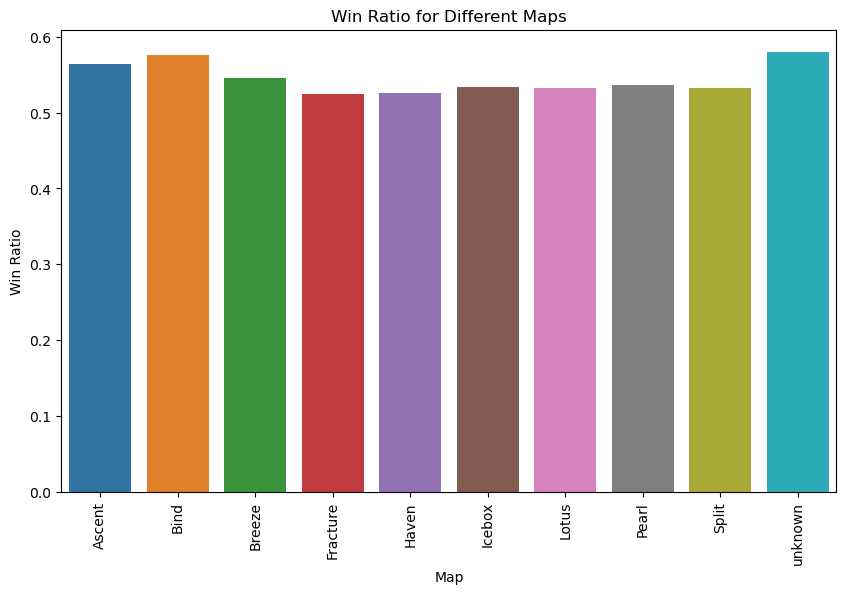

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns



# Group the data by 'map' and calculate win ratio
map_win_ratios = round_totals_normalized_df.groupby('map')['round_won'].mean()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=map_win_ratios.index, y=map_win_ratios.values)
plt.title('Win Ratio for Different Maps')
plt.ylabel('Win Ratio')
plt.xlabel('Map')
plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
plt.show()

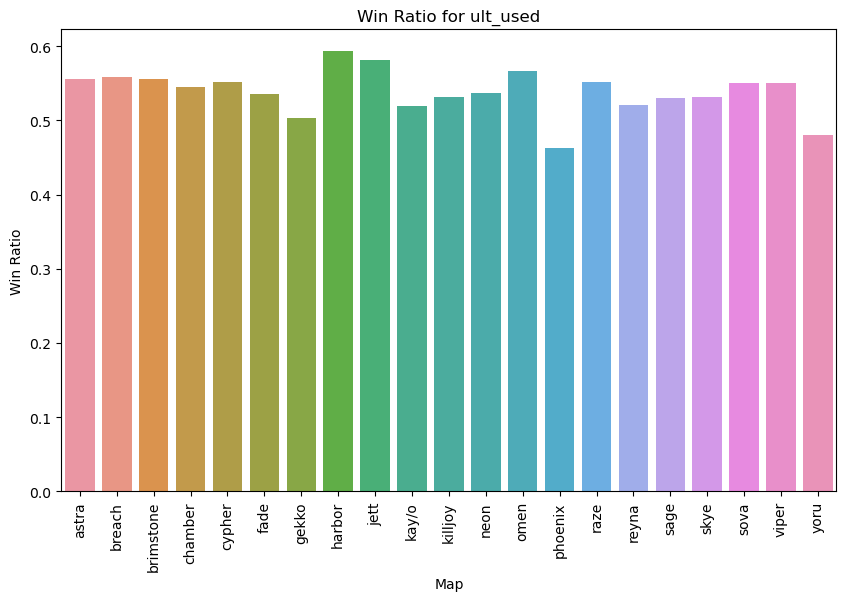

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns



# Group the data by 'map' and calculate win ratio
map_win_ratios = round_totals_normalized_df.groupby('self_character')['round_won'].mean()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=map_win_ratios.index, y=map_win_ratios.values)
plt.title('Win Ratio for ult_used')
plt.ylabel('Win Ratio')
plt.xlabel('Map')
plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
plt.show()

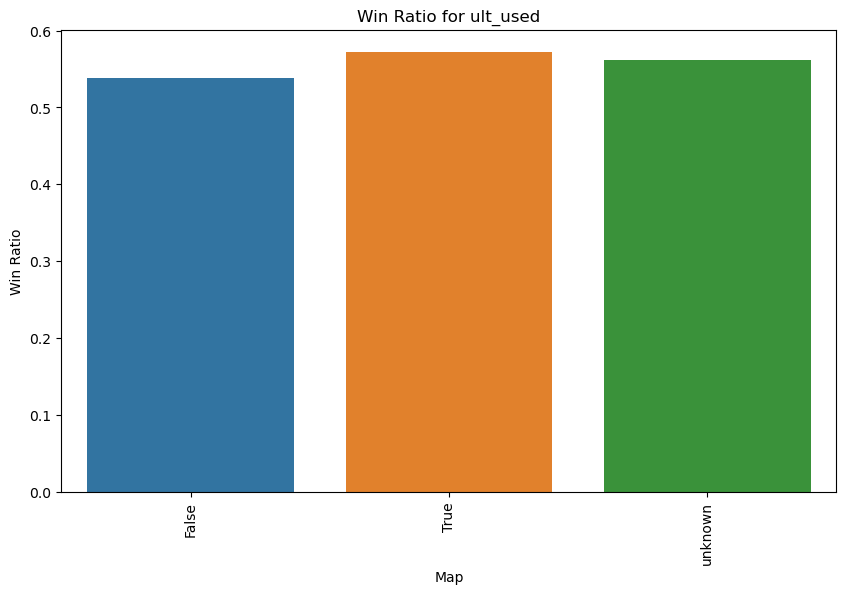

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns



# Group the data by 'map' and calculate win ratio
map_win_ratios = round_totals_normalized_df.groupby('ult_used')['round_won'].mean()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=map_win_ratios.index, y=map_win_ratios.values)
plt.title('Win Ratio for ult_used')
plt.ylabel('Win Ratio')
plt.xlabel('Map')
plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
plt.show()

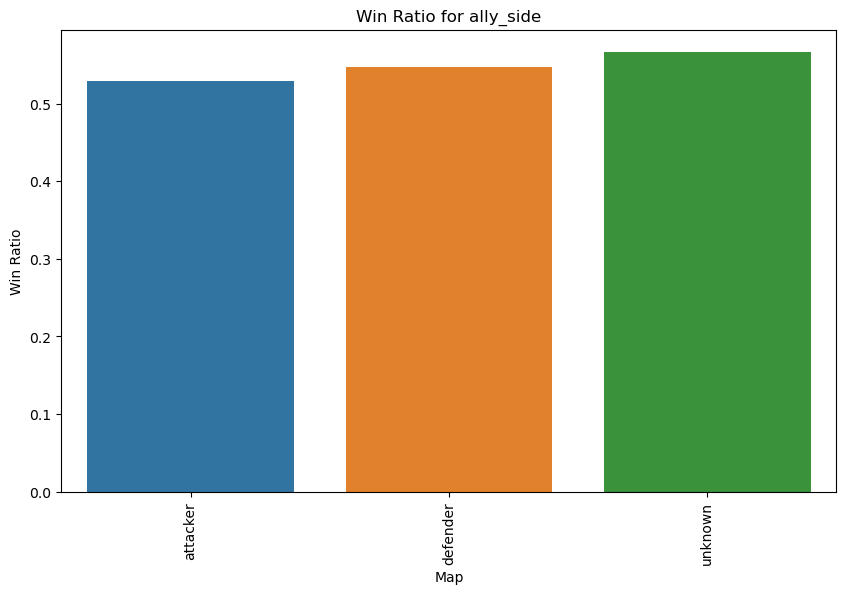

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns



# Group the data by 'map' and calculate win ratio
map_win_ratios = round_totals_normalized_df.groupby('ally_side')['round_won'].mean()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=map_win_ratios.index, y=map_win_ratios.values)
plt.title('Win Ratio for ally_side')
plt.ylabel('Win Ratio')
plt.xlabel('Map')
plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
plt.show()

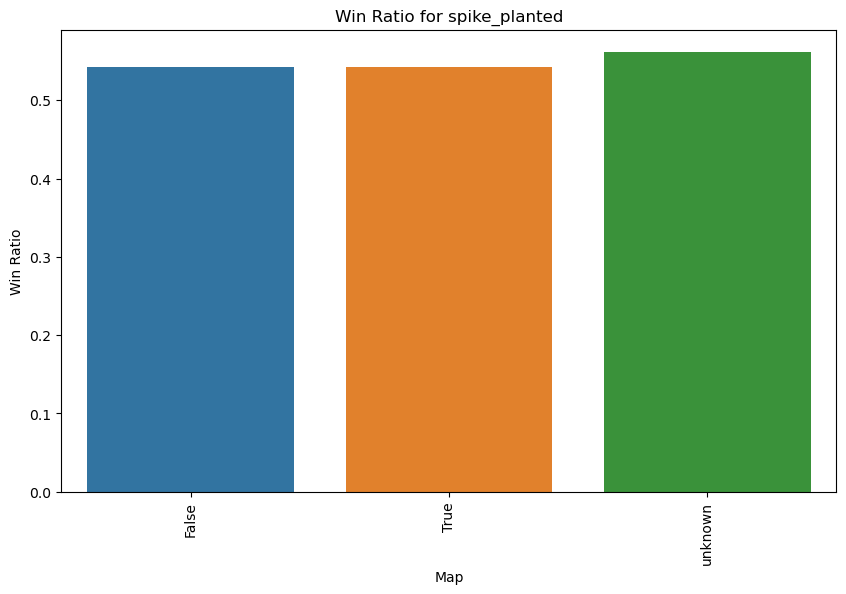

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns



# Group the data by 'map' and calculate win ratio
map_win_ratios = round_totals_normalized_df.groupby('spike_planted')['round_won'].mean()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=map_win_ratios.index, y=map_win_ratios.values)
plt.title('Win Ratio for spike_planted')
plt.ylabel('Win Ratio')
plt.xlabel('Map')
plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees
plt.show()

### Thoughts
- There doesnt seem to be one character or one map or one anything that is at a much higher ratio

## Data pre-processing
- Goal is to predict outcome of a match
- Dropped rows with missing values
- Translated the boolean cols to 0 and 1
- One-hot encode categorical variables
- StandardScaler for numeric ...

### Questions
1. Is one-hot encoding valid here? are there some algorithms that wont work because of this? In particular distance based algorithms (clustering?)
2. Scaling? Only for numeric? What kind of scaling
3. Droping missing rows.. is there a better approach?

### dropping columns I dont think I need for this analysis

In [33]:
round_df = round_totals_normalized_df.drop(['score','buy_start','round_end','ally_score','round_start','round_scored','opponent_score','user_id'], axis=1)


In [34]:
round_df.columns

Index(['ult_used', 'ally_side', 'round_won', 'spike_planted', 'map',
       'self_character', 'elims', 'deaths', 'assists', 'healing', 'headshots',
       'shielding', 'wallbangs', 'first_bloods', 'seconds_dead',
       'was_assisted', 'credits_spent', 'first_blooded', 'seconds_alive',
       'credits_earned', 'hp_damage_taken', 'shield_damage_taken',
       'round_length'],
      dtype='object')

### dropping unknown rows

In [35]:
round_df

,ult_used,ally_side,round_won,spike_planted,map,self_character,elims,deaths,assists,healing,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,False,attacker,1,False,Pearl,jett,0,1,0,0,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,False,attacker,1,False,Pearl,jett,2,0,0,0,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,False,attacker,1,True,Pearl,jett,2,0,1,0,...,1,0,0,200,0,100,3900,0,0,1.169467
3,False,attacker,1,False,Pearl,jett,3,0,0,0,...,1,0,2,350,0,64,1650,23,46,0.577867
4,False,attacker,1,False,Pearl,jett,1,0,0,23,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,unknown,attacker,1,unknown,Lotus,sage,0,1,1,0,...,0,11,0,1050,0,79,300,100,97,1.023050
8042,unknown,attacker,1,unknown,Lotus,sage,0,0,0,0,...,0,0,0,4700,0,64,3000,0,42,0.576583
8043,unknown,attacker,1,unknown,Lotus,sage,2,0,1,21,...,1,0,2,0,0,64,2900,21,85,0.582267
8044,unknown,attacker,1,unknown,Lotus,sage,1,1,1,0,...,0,15,0,5800,0,79,7700,100,50,1.095083


In [36]:
round_df['ult_used'] = round_df['ult_used'].astype(str)
round_df['ally_side'] = round_df['ally_side'].astype(str)
round_df['spike_planted'] = round_df['spike_planted'].astype(str)

In [37]:
round_df = round_df[(round_df['map'] != 'unknown') & 
                    (round_df['ally_side'] != 'unknown') & 
                    (round_df['ult_used'] != 'unknown') & 
                    (round_df['self_character'] != 'unknown') & 
                    (round_df['spike_planted'] != 'unknown')]

# Reset index and drop the old index
round_df = round_df.reset_index(drop=True)
round_df

,ult_used,ally_side,round_won,spike_planted,map,self_character,elims,deaths,assists,healing,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,False,attacker,1,False,Pearl,jett,0,1,0,0,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,False,attacker,1,False,Pearl,jett,2,0,0,0,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,False,attacker,1,True,Pearl,jett,2,0,1,0,...,1,0,0,200,0,100,3900,0,0,1.169467
3,False,attacker,1,False,Pearl,jett,3,0,0,0,...,1,0,2,350,0,64,1650,23,46,0.577867
4,False,attacker,1,False,Pearl,jett,1,0,0,23,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,False,defender,1,False,Split,fade,2,0,0,0,...,0,0,2,3550,0,104,2400,49,25,1.243250
5059,False,defender,0,True,Split,fade,0,1,1,0,...,0,62,0,1700,0,65,3400,100,50,1.629767
5060,False,defender,0,False,Split,fade,0,1,0,0,...,0,16,0,5100,0,52,5200,100,25,0.639483
5061,False,defender,0,True,Split,fade,0,1,0,0,...,0,23,0,3900,0,57,2400,100,50,0.841000


### encoding boolean features


In [38]:
mapping = {'True': 1, 'False': 0}
round_df.loc[:, 'ult_used'] = round_df['ult_used'].map(mapping)

round_df

,ult_used,ally_side,round_won,spike_planted,map,self_character,elims,deaths,assists,healing,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,0,attacker,1,False,Pearl,jett,0,1,0,0,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,0,attacker,1,False,Pearl,jett,2,0,0,0,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,0,attacker,1,True,Pearl,jett,2,0,1,0,...,1,0,0,200,0,100,3900,0,0,1.169467
3,0,attacker,1,False,Pearl,jett,3,0,0,0,...,1,0,2,350,0,64,1650,23,46,0.577867
4,0,attacker,1,False,Pearl,jett,1,0,0,23,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,0,defender,1,False,Split,fade,2,0,0,0,...,0,0,2,3550,0,104,2400,49,25,1.243250
5059,0,defender,0,True,Split,fade,0,1,1,0,...,0,62,0,1700,0,65,3400,100,50,1.629767
5060,0,defender,0,False,Split,fade,0,1,0,0,...,0,16,0,5100,0,52,5200,100,25,0.639483
5061,0,defender,0,True,Split,fade,0,1,0,0,...,0,23,0,3900,0,57,2400,100,50,0.841000


In [39]:
mapping = {'attacker': 1, 'defender': 0}
round_df.loc[:, 'ally_side'] = round_df['ally_side'].map(mapping)
round_df

,ult_used,ally_side,round_won,spike_planted,map,self_character,elims,deaths,assists,healing,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,0,1,1,False,Pearl,jett,0,1,0,0,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,0,1,1,False,Pearl,jett,2,0,0,0,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,0,1,1,True,Pearl,jett,2,0,1,0,...,1,0,0,200,0,100,3900,0,0,1.169467
3,0,1,1,False,Pearl,jett,3,0,0,0,...,1,0,2,350,0,64,1650,23,46,0.577867
4,0,1,1,False,Pearl,jett,1,0,0,23,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,0,0,1,False,Split,fade,2,0,0,0,...,0,0,2,3550,0,104,2400,49,25,1.243250
5059,0,0,0,True,Split,fade,0,1,1,0,...,0,62,0,1700,0,65,3400,100,50,1.629767
5060,0,0,0,False,Split,fade,0,1,0,0,...,0,16,0,5100,0,52,5200,100,25,0.639483
5061,0,0,0,True,Split,fade,0,1,0,0,...,0,23,0,3900,0,57,2400,100,50,0.841000


In [40]:
mapping = {'True': 1, 'False': 0}
round_df.loc[:, 'spike_planted'] = round_df['spike_planted'].map(mapping)
round_df

,ult_used,ally_side,round_won,spike_planted,map,self_character,elims,deaths,assists,healing,...,first_bloods,seconds_dead,was_assisted,credits_spent,first_blooded,seconds_alive,credits_earned,hp_damage_taken,shield_damage_taken,round_length
0,0,1,1,0,Pearl,jett,0,1,0,0,...,0,71,0,4760,0,53,9860,100,24,2.001317
1,0,1,1,0,Pearl,jett,2,0,0,0,...,0,0,1,4750,0,79,3300,0,0,0.826667
2,0,1,1,1,Pearl,jett,2,0,1,0,...,1,0,0,200,0,100,3900,0,0,1.169467
3,0,1,1,0,Pearl,jett,3,0,0,0,...,1,0,2,350,0,64,1650,23,46,0.577867
4,0,1,1,0,Pearl,jett,1,0,0,23,...,0,0,0,8550,0,79,3300,23,0,0.829267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,0,0,1,0,Split,fade,2,0,0,0,...,0,0,2,3550,0,104,2400,49,25,1.243250
5059,0,0,0,1,Split,fade,0,1,1,0,...,0,62,0,1700,0,65,3400,100,50,1.629767
5060,0,0,0,0,Split,fade,0,1,0,0,...,0,16,0,5100,0,52,5200,100,25,0.639483
5061,0,0,0,1,Split,fade,0,1,0,0,...,0,23,0,3900,0,57,2400,100,50,0.841000


### one-hot encoding on 'map' and 'self_character' columns

In [41]:
df_encoded = pd.get_dummies(round_df, columns=['map', 'self_character'])
df_encoded

,ult_used,ally_side,round_won,spike_planted,elims,deaths,assists,healing,headshots,shielding,...,self_character_neon,self_character_omen,self_character_phoenix,self_character_raze,self_character_reyna,self_character_sage,self_character_skye,self_character_sova,self_character_viper,self_character_yoru
0,0,1,1,0,0,1,0,0,0,24,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,2,0,0,0,2,50,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,2,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,3,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,23,0,46,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,0,0,1,0,2,0,0,0,1,25,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,1,0,1,1,0,0,50,...,0,0,0,0,0,0,0,0,0,0
5060,0,0,0,0,0,1,0,0,0,25,...,0,0,0,0,0,0,0,0,0,0
5061,0,0,0,1,0,1,0,0,0,50,...,0,0,0,0,0,0,0,0,0,0


### Downsampling

In [42]:
# downsampling for now
class_win = df_encoded[df_encoded['round_won'] == 1]
class_loss = df_encoded[df_encoded['round_won'] == 0]

num_samples_class_win = len(class_win)
num_samples_class_loss = len(class_loss)

downsampled_class_win = class_win.sample(n=num_samples_class_loss, random_state=42)
downsampled_class_loss = class_loss

# Combine the downsampled classes into a new data frame
downsampled_df = pd.concat([downsampled_class_win, downsampled_class_loss])

downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
downsampled_df

,ult_used,ally_side,round_won,spike_planted,elims,deaths,assists,healing,headshots,shielding,...,self_character_neon,self_character_omen,self_character_phoenix,self_character_raze,self_character_reyna,self_character_sage,self_character_skye,self_character_sova,self_character_viper,self_character_yoru
0,0,0,1,0,1,1,1,0,1,50,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,2,0,0,0,2,50,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,3,1,0,0,1,25,...,0,0,0,1,0,0,0,0,0,0
3,1,1,0,0,0,1,0,0,0,24,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,25,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4705,0,0,0,1,1,1,0,0,1,50,...,0,0,0,0,0,0,0,0,0,0
4706,0,0,1,0,1,0,0,0,1,50,...,0,0,0,0,0,0,0,0,0,0
4707,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4708,0,1,0,0,0,1,0,0,0,38,...,0,0,0,0,0,0,0,0,0,0


## LogReg
- Used two different feature selection methods, FFS and PCA
- Not really a huge fan of PCA becuase we loose information about what features are important (goal of this analysis)
- Currently this dataset is just overall (attacker and defender)
- Could be potentail baseline model?

hyperparameters to consider tuning:
- **C**: This is the inverse of regularization strength (prevent overfitting by discoraging complex models)
- **penalty** (**l1_ratio**): regularization term
- **solver**: type of solver the algorithm will use to optimize

### Scaling
- StandardScaler works by removing the mean and scaling to unit variance
- Per-feature basis, independently transforming each feature to have a mean of 0 and a standard deviation of 1
- Important for gradient descent-based methods or distance-based calculations

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# train test split
X = downsampled_df.drop('round_won', axis=1)
y = downsampled_df['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

predictions = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Accuracy: 0.7484076433121019
Precision: 0.8356545961002786
Recall: 0.6276150627615062
F1 score: 0.7168458781362008


/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### PCA
- Still 40 components? that a lot

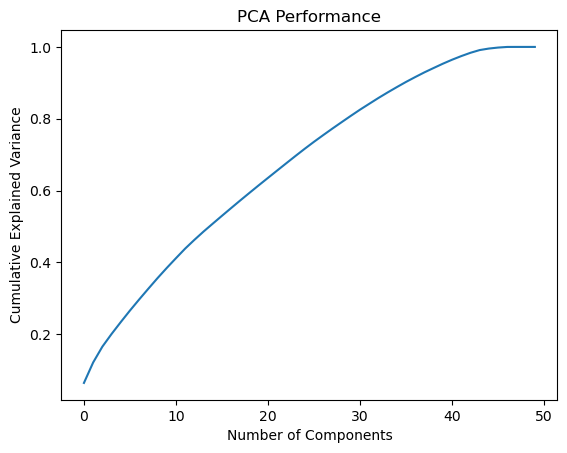

Number of components that explain 95% of variance: 40
Accuracy: 0.7709772951628825
Precision: 0.7755905511811023
Recall: 0.76953125
F1 score: 0.7725490196078431


In [156]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# train test split
X = df_encoded.drop('round_won', axis=1)
y = df_encoded['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting pca
pca = PCA().fit(X_train_scaled)

# plotting explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Performance')
plt.show()

# select the number of components that explain a certain percentage of the variance
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1
print(f"Number of components that explain 95% of variance: {n_components}")

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# fitting logreg model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_pca, y_train)

predictions = logistic_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

### FFS
- if you died, and if you died first

In [168]:
n_features_to_select_range = list(range(1, 7))
n_features_to_select_range

[1, 2, 3, 4, 5, 6]

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

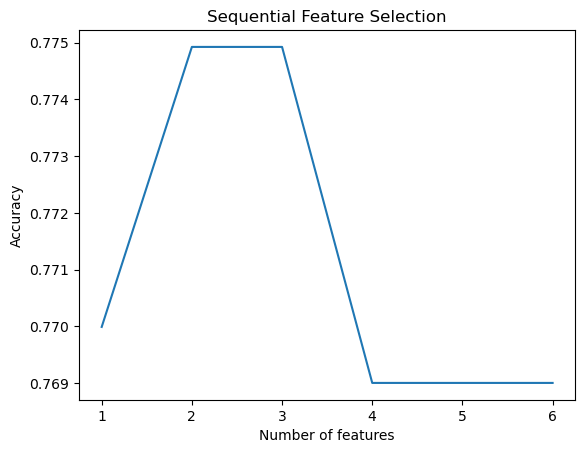

Best number of features: 2
Accuracy: 0.7749259624876604
Precision: 0.8034188034188035
Recall: 0.734375
F1 score: 0.7673469387755102


In [169]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_encoded.drop('round_won', axis=1)
y = df_encoded['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 7))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

# train test split
X = downsampled_df.drop('round_won', axis=1)
y = downsampled_df['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=2)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

# Make predictions on the training set
train_predictions = logistic_model.predict(X_train_selected)

# Compute the metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

# Print the metrics
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {train_precision}')
print(f'Training Recall: {train_recall}')
print(f'Training F1 score: {train_f1}')

Index(['deaths', 'first_bloods'], dtype='object')
Accuracy: 0.7622080679405521
Precision: 0.7912844036697247
Recall: 0.7217573221757322
F1 score: 0.7549234135667396
Training Accuracy: 0.7526539278131635
Training Precision: 0.7875836883749239
Training Recall: 0.6893979754928077
Training F1 score: 0.7352272727272727


## splitting the data by attack/defend
What if you are attacker? is not dying still the goal?

For attack:
- 5 features is best
- 'spike_planted', 'deaths', 'assists', 'first_bloods', 'seconds_dead'

For defend:
- 9+ is best, but its not converging... (seems to be a harder problem?)
- 'spike_planted', 'deaths', 'assists', 'shielding', 'first_bloods','seconds_dead', 'first_blooded', 'round_length', 'self_character_astra'

Seems like in both cases whether or not the spike has been planted is a driver, as well as not dying. Interestingly, assists are particuarly relevant in both cases. Also interestingly, first bloods was relevant for the defensive side (not the attacking side as expected). 

In [173]:
df_attack = downsampled_df.loc[downsampled_df['ally_side'] == 1]
df_defend = downsampled_df.loc[downsampled_df['ally_side'] == 0]

In [174]:
df_attack

,ult_used,ally_side,round_won,spike_planted,elims,deaths,assists,healing,headshots,shielding,...,self_character_neon,self_character_omen,self_character_phoenix,self_character_raze,self_character_reyna,self_character_sage,self_character_skye,self_character_sova,self_character_viper,self_character_yoru
3,1,1,0,0,0,1,0,0,0,24,...,0,0,0,0,0,0,0,1,0,0
5,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,1,1,1,0,1,0,0,0,50,...,0,0,0,0,0,0,1,0,0,0
10,0,1,1,1,0,0,1,0,0,50,...,0,1,0,0,0,0,0,0,0,0
12,0,1,0,1,0,1,0,0,0,50,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,0,1,1,1,0,1,0,0,0,25,...,0,0,0,0,0,0,0,0,0,0
4702,0,1,0,0,0,0,0,0,0,50,...,0,0,0,0,0,0,0,0,1,0
4703,0,1,0,1,0,1,0,0,0,50,...,0,0,0,0,0,0,0,0,0,0
4707,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
df_defend

,ult_used,ally_side,round_won,spike_planted,elims,deaths,assists,healing,headshots,shielding,...,self_character_neon,self_character_omen,self_character_phoenix,self_character_raze,self_character_reyna,self_character_sage,self_character_skye,self_character_sova,self_character_viper,self_character_yoru
0,0,0,1,0,1,1,1,0,1,50,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,2,0,0,0,2,50,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,3,1,0,0,1,25,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,25,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,1,3,1,0,100,1,125,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700,0,0,1,1,1,1,3,0,1,50,...,0,0,0,0,0,0,0,1,0,0
4704,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4705,0,0,0,1,1,1,0,0,1,50,...,0,0,0,0,0,0,0,0,0,0
4706,0,0,1,0,1,0,0,0,1,50,...,0,0,0,0,0,0,0,0,0,0


/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


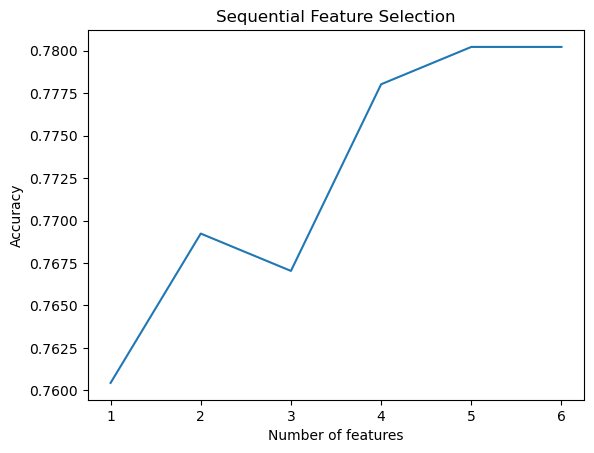

Best number of features: 5
Accuracy: 0.7802197802197802
Precision: 0.794392523364486
Recall: 0.7522123893805309
F1 score: 0.7727272727272728


In [176]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_attack.drop('round_won', axis=1)
y = df_attack['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 7))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

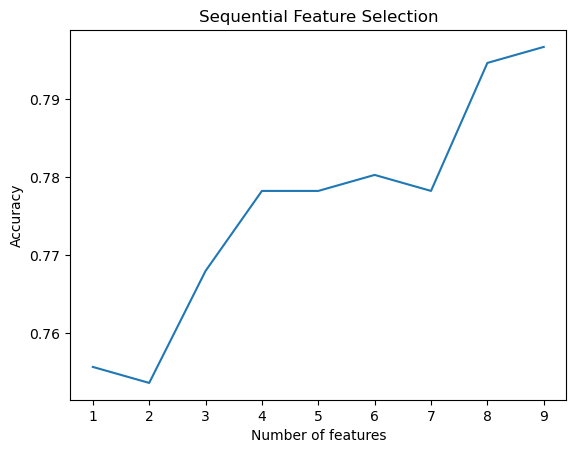

Best number of features: 9
Accuracy: 0.7967145790554415
Precision: 0.8481675392670157
Recall: 0.6982758620689655
F1 score: 0.7659574468085105


/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [179]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_defend.drop('round_won', axis=1)
y = df_defend['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 10))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_attack.drop('round_won', axis=1)
y = df_attack['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=5)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['spike_planted', 'deaths', 'assists', 'first_bloods', 'seconds_dead'], dtype='object')
Accuracy: 0.7802197802197802
Precision: 0.794392523364486
Recall: 0.7522123893805309
F1 score: 0.7727272727272728


In [180]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_defend.drop('round_won', axis=1)
y = df_defend['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=9)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['spike_planted', 'deaths', 'assists', 'shielding', 'first_bloods',
       'seconds_dead', 'first_blooded', 'round_length',
       'self_character_astra'],
      dtype='object')
Accuracy: 0.7761806981519507
Precision: 0.7757847533632287
Recall: 0.7456896551724138
F1 score: 0.7604395604395605


/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## no deaths
What if deaths is not a part of it? 

For all:
- 3 features is best
- 'elims', 'healing', 'hp_damage_taken'

For attack:
- 3 features is best
- 'healing', 'first_bloods', 'hp_damage_taken'

For defend:
- 3 features is best
- 'elims', 'healing', 'hp_damage_taken'

Why is it not picking 'spike_planted', or the features more similar to deaths? like 'first_blooded' or 'seconds_dead', I guess it is picking 'hp_damage_taken'

In [181]:
downsampled_df_nod = downsampled_df.drop('deaths', axis=1)
df_attack_nod = df_attack.drop('deaths', axis=1)
df_defend_nod = df_defend.drop('deaths', axis=1)

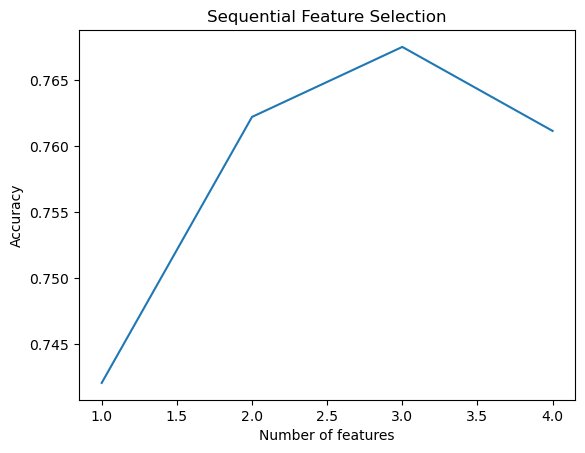

Best number of features: 3
Accuracy: 0.767515923566879
Precision: 0.9575971731448764
Recall: 0.5669456066945606
F1 score: 0.7122207621550591


In [182]:
## all data
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = downsampled_df_nod.drop('round_won', axis=1)
y = downsampled_df_nod['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 5))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = downsampled_df_nod.drop('round_won', axis=1)
y = downsampled_df_nod['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=3)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['elims', 'healing', 'hp_damage_taken'], dtype='object')
Accuracy: 0.767515923566879
Precision: 0.9575971731448764
Recall: 0.5669456066945606
F1 score: 0.7122207621550591


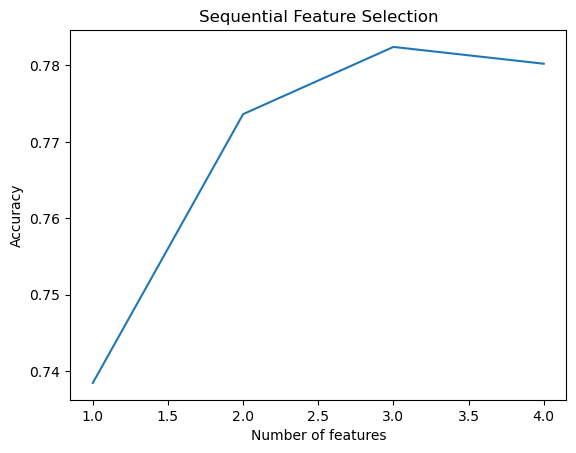

Best number of features: 3
Accuracy: 0.7824175824175824
Precision: 0.8848484848484849
Recall: 0.6460176991150443
F1 score: 0.7468030690537084


In [184]:
## attack
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_attack_nod.drop('round_won', axis=1)
y = df_attack_nod['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 5))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_attack_nod.drop('round_won', axis=1)
y = df_attack_nod['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=3)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['healing', 'first_bloods', 'hp_damage_taken'], dtype='object')
Accuracy: 0.7824175824175824
Precision: 0.8848484848484849
Recall: 0.6460176991150443
F1 score: 0.7468030690537084


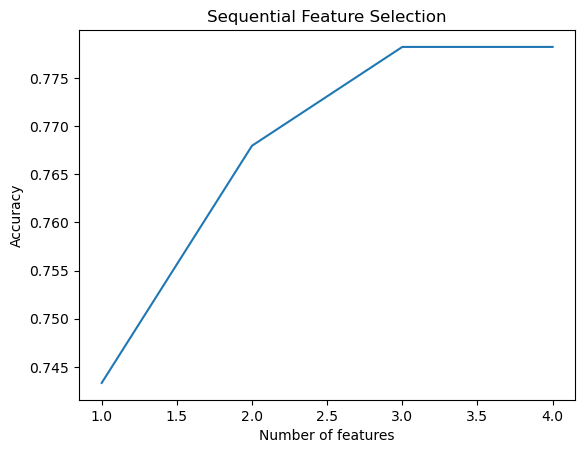

Best number of features: 3
Accuracy: 0.7782340862422998
Precision: 0.9133333333333333
Recall: 0.5905172413793104
F1 score: 0.7172774869109949


In [186]:
## defend
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_defend_nod.drop('round_won', axis=1)
y = df_defend_nod['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 5))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_defend_nod.drop('round_won', axis=1)
y = df_defend_nod['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=3)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['elims', 'healing', 'hp_damage_taken'], dtype='object')
Accuracy: 0.7782340862422998
Precision: 0.9133333333333333
Recall: 0.5905172413793104
F1 score: 0.7172774869109949


## Thoughts
- I was suprised at how logreg did given its simplicity. I beleive getting above 70% accuracy in sports analytics problems is usually considered quite good, however I would like to see if it can be better
- I do think that this simple analysis shows some "common sense" things, like deaths and eliminations being important factors. It seems like map, character are not as relevant as your actual preformance in the game. It seems like not dying is generally more important than getting actual kills. 
- Why is it not picking death-similar metrics when deaths is removed?
- When deaths is removed, precision jumps up but recall falls. My understanding of what this means is the model is "more correct" in ideinifying true wins, but is less able to capture all the positive cases (its missing some).
    - Precision: proportion of correctly predicted positive instances (true positives) out of all instances predicted as positive (avoiding false positives)
    - proportion of correctly predicted positive instances (true positives) out of all actual positive instances (low false negative)
- often when there were too many features, the model didnt converge. possible reasons include:
    - High collinearity
        - the correlation matrix showed some features close to 1 but not THAT many
    - Insufficient data
        - this could def be a problem
    - Non-linear relationships
        - could also be the case, logreg might be a poor model choice
    - Outliers
        - should look into this more


    

## Next steps
- Could try further tuning logreg model
- Could try additional feature engineering (more features, see other notebook)
- Could try getting additional "perspectives"
    - Hypothesis: only having a single person's perspective may be limiting in terms of model acuracy given that this is a team gameF
    - For example, one team member could "carry" the other team members, and from the perspective of the "bad" player, they win the round but with really bad stats
    - Possible to get this data if i could find pro streamers playing with other pro streamers (perhaps in a tournament setting??)
    - Does this content exist? feel kinda lost of how to start looking for this
- Could try a model that can capture non-lineararites in the data (random forrest, GBM, SVM w/ non linear kernel)
- **Could try breaking up the data by pre and post spike plant**
- https://www.google.com/search?q=Survival+Analysis&oq=Survival+Analysis&aqs=chrome..69i57.174j0j1&sourceid=chrome&ie=UTF-8 

In [190]:
df_spike = downsampled_df.loc[downsampled_df['spike_planted'] == 1]
df_nospike = downsampled_df.loc[downsampled_df['spike_planted'] == 0]

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

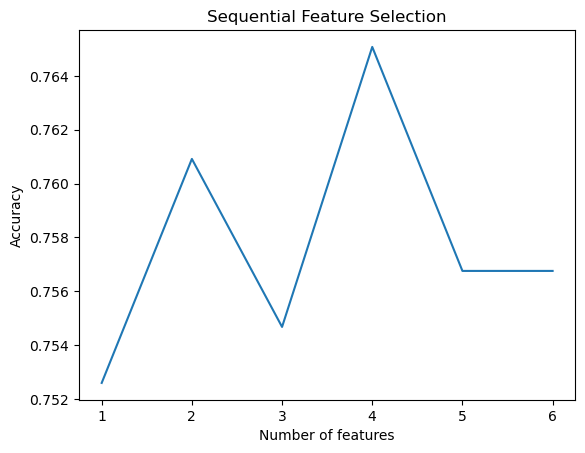

Best number of features: 4
Accuracy: 0.7650727650727651
Precision: 0.788659793814433
Recall: 0.68
F1 score: 0.730310262529833


In [196]:
## spike
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_spike.drop('round_won', axis=1)
y = df_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 7))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_spike.drop('round_won', axis=1)
y = df_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=4)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['ally_side', 'deaths', 'assists', 'self_character_jett'], dtype='object')
Accuracy: 0.7650727650727651
Precision: 0.788659793814433
Recall: 0.68
F1 score: 0.730310262529833


/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

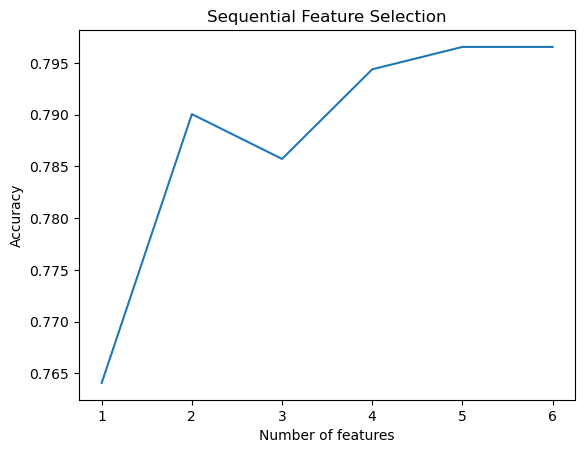

Best number of features: 5
Accuracy: 0.7965367965367965
Precision: 0.8040201005025126
Recall: 0.7441860465116279
F1 score: 0.7729468599033817


In [197]:
## nospike
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_nospike.drop('round_won', axis=1)
y = df_nospike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 7))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_spike.drop('round_won', axis=1)
y = df_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=5)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['ally_side', 'deaths', 'assists', 'self_character_jett',
       'self_character_sage'],
      dtype='object')
Accuracy: 0.7567567567567568
Precision: 0.7727272727272727
Recall: 0.68
F1 score: 0.7234042553191491


In [191]:
df_attack_spike = df_attack.loc[downsampled_df['spike_planted'] == 1]
df_defend_spike = df_defend.loc[downsampled_df['spike_planted'] == 1]

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

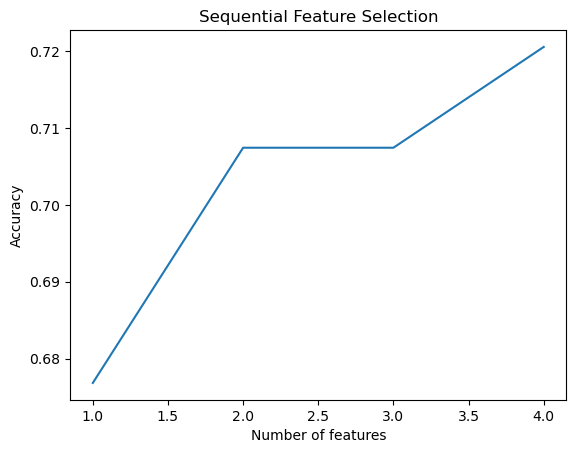

Best number of features: 4
Accuracy: 0.7205240174672489
Precision: 0.7514450867052023
Recall: 0.8609271523178808
F1 score: 0.8024691358024691


In [201]:
## spike attack
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_attack_spike.drop('round_won', axis=1)
y = df_attack_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 5))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_attack_spike.drop('round_won', axis=1)
y = df_attack_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=4)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['deaths', 'assists', 'credits_earned', 'round_length'], dtype='object')
Accuracy: 0.7205240174672489
Precision: 0.7514450867052023
Recall: 0.8609271523178808
F1 score: 0.8024691358024691


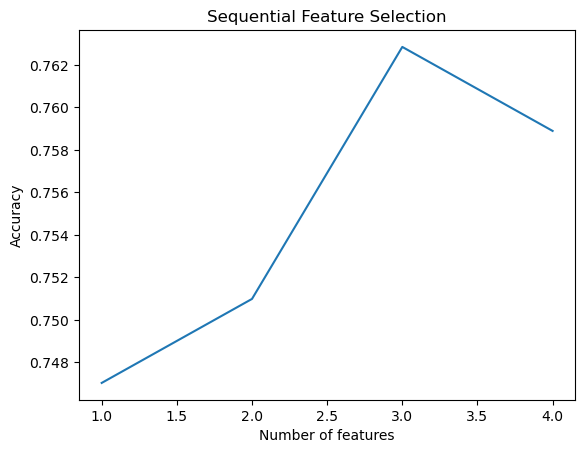

Best number of features: 3
Accuracy: 0.7628458498023716
Precision: 0.7454545454545455
Recall: 0.47126436781609193
F1 score: 0.5774647887323943


In [204]:
## spike defentd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_defend_spike.drop('round_won', axis=1)
y = df_defend_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 5))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_defend_spike.drop('round_won', axis=1)
y = df_defend_spike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=3)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Index(['deaths', 'assists', 'seconds_alive'], dtype='object')
Accuracy: 0.7430830039525692
Precision: 0.6774193548387096
Recall: 0.4827586206896552
F1 score: 0.5637583892617449


In [192]:
df_attack_nospike = df_attack.loc[downsampled_df['spike_planted'] == 0]
df_defend_nospike = df_defend.loc[downsampled_df['spike_planted'] == 0]

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

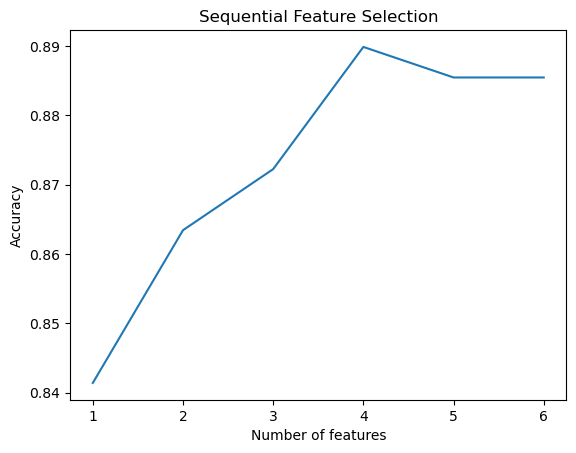

Best number of features: 4
Accuracy: 0.8898678414096917
Precision: 0.9607843137254902
Recall: 0.6805555555555556
F1 score: 0.7967479674796749


In [207]:
## nospike attack
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_attack_nospike.drop('round_won', axis=1)
y = df_attack_nospike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 7))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_attack_nospike.drop('round_won', axis=1)
y = df_attack_nospike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=5)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [ ]:
## no spike defend
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# train test split
X = df_defend_nospike.drop('round_won', axis=1)
y = df_defend_nospike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

logistic_model = LogisticRegression()

# Choose a range for n_features_to_select
n_features_to_select_range = list(range(1, 5))

best_score = -np.inf
best_n_features = None
best_features = None

scores = []

# Run SequentialFeatureSelector for different n_features_to_select
for n in n_features_to_select_range:
    sfs = SequentialFeatureSelector(logistic_model, n_features_to_select=n)
    sfs.fit(X_train, y_train)
    
    # Use the selected features to transform the data
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    
    # Fit and predict using logistic regression model
    logistic_model.fit(X_train_selected, y_train)
    predictions = logistic_model.predict(X_test_selected)

    score = accuracy_score(y_test, predictions)
    scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n_features = n
        best_features = sfs.get_support(indices=True)

# Plot the scores
plt.plot(n_features_to_select_range, scores)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Sequential Feature Selection')
plt.show()

# Fit and predict using logistic regression model with best features
X_train_selected = X_train.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

logistic_model.fit(X_train_selected, y_train)

predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Best number of features: {best_n_features}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# train test split
X = df_defend_nospike.drop('round_won', axis=1)
y = df_defend_nospike['round_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


logistic_model = LogisticRegression()

sfs = SequentialFeatureSelector(log_reg, n_features_to_select=5)

sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(selected_features)


# 'selected_features' is the list of features you got from Forward Feature Selection
X_train_selected = X_train[selected_features]


# Train a logistic regression model using these selected features
logistic_model.fit(X_train_selected, y_train)

# Apply the same feature selection to your test/validation data
X_test_selected = X_test[selected_features]

# Make predictions
predictions = logistic_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')